
<img src="http://hydrology.usu.edu/images/taudem5logo.gif" style="float:left;width:300px;padding:20px">       


# TauDEM Raster Processing Notebook

<br>
This notebook demonstrates basic watershed processing using the TauDEM GIS library.  For more information about TauDEM, see http://hydrology.usu.edu/taudem/taudem5/.  This tutorial is divided into the following three categories:

* [Setup and Preparation](#setup)
* [GIS Processing using TauDEM](#gis)
* [New Resource Creation using HydroShare](#creation)


### 1. Script Setup and Preparation
<a name="setup"></a>

Before we begin GIS processing, we must import several libaries into the notebook.  The **hs_utils** library provides functions for interacting with HydroShare, including resource querying, dowloading and creation.  The **taudem** libary provides functions for simplifying the TauDEM GIS commands, workspace maintenance, as well as visualization. Finally, the `%matplotlib inline` command tells the notebook server to place plots and figures directly into the notebook. 

**Note:** You may see some matplotlib warnings if this is the first time you are running this notebook.  These warnings can be ignored.


In [1]:
# import required libaries for geoprocessing
import os
import hs_utils
import taudem
%matplotlib inline

Next we need to establish a secure connection with HydroShare.  This is done by simply instantiating the `hydroshare` class that is defined within `hs_utils`.  In addition to connecting with HydroShare, this command also sets environment variables for several parameters that may useful to you: 

1. Your username
2. The ID of the resource which launched the notebook
3. The type of resource that launched this notebook
4. The url for the notebook server.

In [2]:
# establish a secure connection to HydroShare
hs = hs_utils.hydroshare()

Adding the following system variables:
   HS_USR_NAME = TonyCastronova
   HS_RES_ID = 927094481da54af38ffb6f0c39ad8787
   HS_RES_TYPE = genericresource
   JUPYTER_HUB_IP = jupyter.uwrl.usu.edu

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => TonyCastronova


### Retrieve a raster resource using its ID

This example uses a digital elevation model (DEM) that is stored in HydroShare at the following url: https://www.hydroshare.org/resource/6ee06abb2ed8414f9b66d229c8e9a129/ .  The data for our processing routines can be retrieved using the `getResourceFromHydroShare` function by passing in the global identifier from the url above.

In [3]:
# get some resource content. The resource content is returned as a dictionary
content = hs.getResourceFromHydroShare('6ee06abb2ed8414f9b66d229c8e9a129')

This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? y
                      


Two files were downloaded to the Python notebook server: 

1. logan.tiff
2. logan.vrt

We will be using the logan.tiff file as the starting point for our GIS processing.


### Prepare a directory for output files

The `taudem` library consists of utility functions for GIS processing.  The `create_workspace` function will build a clean directory for our GIS processing results.

In [4]:
# prepare a clean workspace for TauDEM output files
data_directory = taudem.create_workspace('logan_data_processing')   

This directory already exists.
Would you like to remove it [Y/n]? y
A clean directory has been created


---


##  Raster Processing
<a name="gis"></a>

The following operations demonstrate how TauDEM can be used to perform basic raster processes. See the following link for more information on TauDEM:  
http://hydrology.usu.edu/taudem/taudem5/TauDEM53CommandLineGuide.pdf

### 1. View the Raw DEM

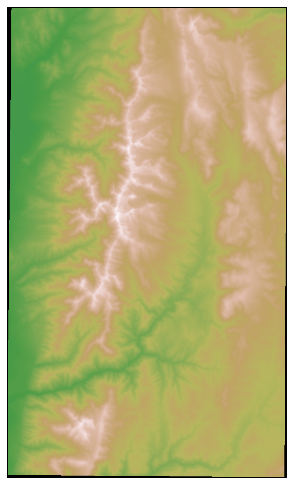

In [5]:
# display the raw dem
raw_dem_path = hs.content['logan.tif']
taudem.plot_tiff(raw_dem_path)

### 2. Remove DEM Pits

In [ ]:
# Fill the DEM Pits

# set the output paths
fill = os.path.join(data_directory, 'loganfel.tif')
cmd = 'pitremove -z %s -fel %s' % (raw_dem_path, fill)
taudem.run_cmd(cmd, processors=4)

### 3. Calculate Flow Directions

In [ ]:
#####################
# D8 Flow Direction #
#####################

# set the output paths 
fdr = os.path.join(data_directory, 'fdr.tif')  # flowdir
sd8 = os.path.join(data_directory, 'sd8.tif')  # slope

cmd = 'd8flowdir -fel %s -sd8 %s -p %s' % (fill, sd8, fdr)
taudem.run_cmd(cmd, processors=4)


In [ ]:
#######################
# DInf Flow direction #
#######################

# set the output paths 
ang = os.path.join(data_directory, 'loganang.tif')  # flow angle
slp = os.path.join(data_directory, 'loganslp.tif')  # flow slope

cmd = 'dinfflowdir -fel %s -ang %s -slp %s' % (fill, ang, slp)
taudem.run_cmd(cmd, processors=4)


#### Plot the Results

In [ ]:
taudem.plot_tiff(tiff=[fdr, ang], title=['D8 Flow Direction', 'DInf Flow Angle'])
taudem.plot_tiff(tiff=[sd8, slp], title=['D8 Slope', 'DInf Slope'])

### 4. Calculate Contributing Area

In [ ]:
########################
# D8 Contributing Area #
########################

# set the output paths
ad8 = os.path.join(data_directory, 'loganad8.tif')  # D8 contributing area

# build the taudem command
cmd = 'aread8 -p %s -ad8 %s' % (fdr, ad8)
# -p:   D8 flow direction output file   
# -ad8: D8 contributing area file (output)  

# run the command
taudem.run_cmd(cmd, processors=4)

In [ ]:
##########################
# DInf Contributing Area #
##########################

# set the output paths
sca = os.path.join(data_directory, 'logansca.tif')  # D-Infinity contributing area

# build the taudem command
cmd = 'areadinf -ang %s -sca %s' % (ang, sca)                         
# -ang: D-infinity flow direction input file.                                  
# -sca: D-infinity area output file.                                             

# run the command
taudem.run_cmd(cmd, processors=4)

---
## Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.


***Optional*** : define the resource from which this "new" content has been derived.  This is one method for tracking resource provenance.

In [ ]:
# define HydroShare required metadata
title = 'TauDEM Processing of Logan Watershed'
abstract = 'This a group of TauDEM processing results that were derived using the Logan River DEM.'
keywords = ['TauDEM', 'Logan River', 'Geoprocessing']

# set the resource type that will be created.
rtype = 'genericresource'

# create a list of files that will be added to the HydroShare resource.
files = [hs.content['logan.tif'], # input DEM for Logan Watershed
         'taudem.ipynb',          # this notebook
         fill, # pit fill dem
         fdr,  # D8 flow direction
         sd8,  # D8 slope
         ang,  # DInf flow angle
         slp,  # DInf slope
         ad8,  # D8 contributing area
         sca   # DInf contributing area
        ]  

# Set the Logan DEM resource as the "parent" 
# (i.e. the new resource will be "derived from" the "6ee06abb2ed8414f9b66d229c8e9a129 resource)
parent_resource = '6ee06abb2ed8414f9b66d229c8e9a129'


In [ ]:
# create a hydroshare resource containing these data
resource_id = hs.createHydroShareResource(abstract, 
                                          title, 
                                          derivedFromId=parent_resource,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)